<a href="https://colab.research.google.com/github/lucaznguyen/understand-cl/blob/main/Toward_CF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

import torch
import torchvision

from torchvision import datasets
from torchvision import transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim
import torch.nn.init as init

from keras.regularizers import l2

from tensorflow.keras.applications import inception_v3, vgg16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.layers import Input, InputLayer, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D
from tensorflow.keras.models import Model

import keras
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10, mnist
import numpy as np
import os

#Mount drive

In [2]:
%cd drive/MyDrive/Paper/Toward Understand CF/datasets

/content/drive/MyDrive/Paper/Toward Understand CF/datasets


#Import data

##Rot-MNIST

In [210]:
train_valid = np.loadtxt('mnist_rotation_new/mnist_all_rotation_normalized_float_train_valid.amat')

In [211]:
X = []
y = []

for data in train_valid:
  y.append(int(data[-1]))
  X.append(data[:-1])

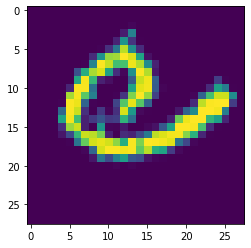

In [212]:
plt.imshow(X[0].reshape(28, 28))
plt.show()

# MNIST

In [17]:
(X, y), (X_test, y_test_raw) = mnist.load_data()
assert X.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y.shape == (60000,)
assert y_test_raw.shape == (10000,)

In [18]:
X_flatten = []
for data in X:
  X_flatten.append(data.reshape(784))

X = X_flatten

X_flatten = []
for data in X_test:
  X_flatten.append(data.reshape(784))

X_test = X_flatten

In [19]:
X_train, X_val, y_train_raw, y_val_raw = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train = np.array(X_train)
X_val = np.array(X_val)

In [21]:
y_train = tf.keras.utils.to_categorical(y_train_raw, num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val_raw, num_classes=10)
print('y_train.shape', y_train.shape)
print(y_train[:3])

y_train.shape (48000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [216]:
test = np.loadtxt('mnist_rotation_new/mnist_all_rotation_normalized_float_test.amat')

In [217]:
X_test = []
y_test_raw = []

for data in test:
  y_test_raw.append(int(data[-1]))
  X_test.append(data[:-1])

y_test = tf.keras.utils.to_categorical(y_test_raw, num_classes=10)

In [218]:
X_test = np.array(X_test)

# Create MLP Backbone

In [52]:
def MLP_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(784, activation='relu')(inputs)
    X = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    #for layer in pretrained_model.layers: 
    #    layer.trainable = False
    return model

In [59]:
def Transfer_model():

    #pretrained_model  = keras_efficientnet_v2.EfficientNetV2M(dropout=1e-6, num_classes=0,pretrained="imagenet",include_preprocessing=True)
    pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
    pretrained_model.trainable = False
    last_output = pretrained_model.output
    x = Flatten(x)
    x = Dense(784, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)

    outputs = Dense(10, activation='softmax')(x)
    model = Model(inputs=pretrained_model.input, outputs=outputs)
    #for layer in pretrained_model.layers: 
    #    layer.trainable = False
    return model

# Define some functions

In [23]:
def batch_data(X, y, batch_size):
  import random

  batch_index = []
  for i in range(batch_size):
    n = random.randint(0, len(X)-1)
    batch_index.append(n)
  return X[batch_index], y[batch_index]

In [24]:
def reservoir(buffer, buffer_size, X, y, z):
  import random

  X_list = []
  y_list = []
  z_list = []
  if len(buffer) > 0:
    X_list = list(buffer[0])
  for data in X:
    X_list.append(data)

  if len(buffer) > 0:
    y_list = list(buffer[1])
  for data in y:
    y_list.append(data)

  if len(buffer) > 0:
    z_list = list(buffer[2])
  for data in y:
    z_list.append(data)

  list_index = []

  n = len(X_list)

  for i in range(n):
    list_index.append(i)

  res = [0]*buffer_size
  for i in range(buffer_size):
      res[i] = list_index[i]

  for i in range(n):
    j = random.randrange(i + 1)
    if(j < buffer_size):
        res[j] = list_index[i]
    i = i + 1

  return [np.array(X_list)[res], np.array(y_list)[res], np.array(z_list)[res]]

In [90]:
def reservoir(buffer, buffer_size, X, y, z):
  import random

  X_list = []
  y_list = []
  z_list = []
  if len(buffer) > 0:
    X_list = list(buffer[0])
  for data in X:
    X_list.append(data)

  if len(buffer) > 0:
    y_list = list(buffer[1])
  for data in y:
    y_list.append(data)

  if len(buffer) > 0:
    z_list = list(buffer[2])
  for data in z:
    z_list.append(data)

  list_index = []

  n = len(X_list)

  for i in range(n):
    list_index.append(i)

  res = [0]*buffer_size
  for i in range(buffer_size):
      res[i] = list_index[i]

  for i in range(n):
    j = random.randrange(i + 1)
    if(j < buffer_size):
        res[j] = list_index[i]
    i = i + 1

  return [np.array(X_list)[res], np.array(y_list)[res], np.array(z_list)[res]]

In [77]:
def check_reservoir(num_seen, buffer_size):
  if num_seen < buffer_size:
      return num_seen

  rand = np.random.randint(0, num_seen + 1)
  # print(rand)
  if rand < buffer_size:
      return rand
  else:
      return -1

In [79]:
num_seen = 0

for i in range(300):
  print(check_reservoir(num_seen, 200))
  num_seen = num_seen + 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
134
182
174
160
199
199
107
192
66
55
74
110
147
153
15
-1
41
53
15
-1
91
150
134
30
139
49
103
14
98
93
149
7
49
185
62
44
73
-1
195
-1
152
18
123
111
43
30
64
22
52
-1
143
-1
-1
-1
-1
56
51
84
56
49
-1
79
163
173
-1
145
11
44
58
162
-1
92
136
-1
-1
56
146
67
121
194
91
198
38
-1
-1
-1
68
137
129
37
143
26
7

## Empirical predict

In [25]:
def empirical_predict(model, X, y):
  acc = 0
  prob = model(X)

  # return 0

  n = len(prob)
  for i in range(n):
    label = list(prob[i]).index(max(list(prob[i])))
    if label == y[i]:
      acc = acc + 1
  return acc/n

In [26]:
def LEEP(y_train, feature_extract):
  import math
  sum = 0
  n = len(y_train)
  n_z = len(feature_extract[0])
  p_yz = init_zero_2d_arr(n_z, 10)
  # print(len(p_yz))
  p_z = init_zero_1d_arr(n_z)
  for z in range(n_z):
    for i in range(n):
      # print("i",i)
      # print("z",z)
      # print(y_train[i][0])
      p_yz[z][y_train[i]]=p_yz[z][y_train[i]]+feature_extract[i][z]/n
      p_z[z] = p_z[z]+feature_extract[i][z]/n

  for i in range(n):
    # print(i)
    sum_log = 0
    for z in range(n_z):
      # sum_log = sum_log + p_yz[y_train[i]][z]/p_z[z]*prob_conditional(i, y_train, z, feature_extract)*feature_extract[i][z]
      sum_log = sum_log + p_yz[z][y_train[i]]/p_z[z]*feature_extract[i][z]
    sum = sum + math.log(sum_log)/n
  sum = sum
  return sum

# Check model and functions

In [38]:
model = MLP_model(input_shape=len(X[0]))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD()

batch_size = 128#len(X_train)

epochs = 1

buffer_size = 200

alpha  = 0.5

lr = 0.2

buffer = []

# Iterate over the batches of a dataset.
for i in range(epochs):
    iterations = len(X_train)//batch_size
    for j in range(iterations):
      if len(buffer) > 0:
        X_buffer, y_buffer, z_buffer = buffer[0], buffer[1], buffer[2]
        X_buffer_batch, y_buffer_batch = batch_data(X_buffer, y_buffer, batch_size)
        reg = np.linalg.norm(z_buffer-model(X_buffer))
      else:
        reg = 0
      X_batch, y_batch = batch_data(X_train, y_train, batch_size)
      with tf.GradientTape() as tape:
          # get_logits = Model(inputs=model.input,
          #                        outputs=model.get_layer(model.layers[-2].name).output)
          # z_batch = get_logits(X_batch)
          logits = model(X_batch)
          # Compute the loss value for this batch.
          loss_value = lr*loss_fn(y_batch, logits) #+ alpha*reg

      # Update the weights of the model to minimize the loss value.
      gradients = tape.gradient(loss_value, model.trainable_weights)
      optimizer.apply_gradients(zip(gradients, model.trainable_weights))
      # buffer = reservoir(buffer, buffer_size, X_batch, y_batch, z_batch)
    # print(len(buffer))
    # print("epoch:", i, "loss:", loss_value, "acc:", empirical_predict(model, X_val, y_val_raw))

model.evaluate(X_val, y_val)

375/375 [==============================] - 2s 4ms/step - loss: 0.4482 - accuracy: 0.8779


[0.44818463921546936, 0.877916693687439]

In [33]:
len(X_train)

48000

In [82]:
np.linalg.norm(np.array([1, 2])-np.array([3, 4]))

2.8284271247461903

In [75]:
model(X_test)

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[3.9795211e-01, 1.7102645e-04, 2.4633227e-01, ..., 6.6548742e-02,
        2.7387010e-02, 1.4115053e-02],
       [7.2294194e-01, 5.8861752e-07, 1.9817117e-01, ..., 2.8166061e-03,
        4.6425276e-03, 2.2170534e-04],
       [2.8577599e-01, 1.9321065e-05, 1.9883229e-01, ..., 1.9709501e-01,
        1.6079638e-02, 1.8943820e-02],
       ...,
       [9.6338633e-03, 4.9477781e-05, 2.2330265e-02, ..., 4.5664439e-01,
        7.9630846e-03, 1.7099804e-01],
       [2.3193299e-03, 5.4292206e-04, 1.8454993e-02, ..., 5.8339026e-02,
        3.0026104e-02, 4.3316597e-01],
       [3.3458009e-02, 1.4445331e-04, 3.1623367e-02, ..., 4.7755054e-01,
        1.3066890e-02, 1.4794989e-01]], dtype=float32)>

In [150]:
model = MLP_model(input_shape=len(X[0]))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

epochs=1

history = model.fit(
  x=X_train,
  y=y_train,
  batch_size=10,
  validation_data=(X_test, y_test), 
  # train_ds,
  # validation_data=val_ds,
  epochs=epochs, 
  # callbacks=[MC]
)

960/960 [==============================] - 6s 6ms/step - loss: 1.9144 - accuracy: 0.3092 - val_loss: 1.4374 - val_accuracy: 0.5004


In [70]:
model(X_test)

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[5.1303023e-01, 1.0745070e-03, 9.1011807e-02, ..., 8.1859261e-02,
        2.7702602e-02, 2.7623925e-02],
       [8.9694059e-01, 1.7658775e-05, 5.5200361e-02, ..., 5.6980941e-03,
        4.8119253e-03, 5.7830114e-04],
       [2.3786604e-01, 2.9438184e-04, 6.6927485e-02, ..., 2.8218746e-01,
        7.1542193e-03, 4.5566607e-02],
       ...,
       [5.4793381e-03, 4.3462752e-04, 1.6038278e-02, ..., 3.7326452e-01,
        4.8098788e-03, 1.9639176e-01],
       [1.4940993e-02, 2.8514990e-03, 4.2365465e-02, ..., 1.1830009e-01,
        5.7186630e-02, 1.6145900e-01],
       [2.8890099e-02, 1.8374528e-03, 3.2292109e-02, ..., 4.2044598e-01,
        1.1044991e-02, 1.5753406e-01]], dtype=float32)>

In [34]:
_, acc = model.evaluate(X_test, y_test)

print(acc)

1563/1563 [==============================] - 7s 4ms/step - loss: 0.5944 - accuracy: 0.8628
0.8628399968147278


# Setup experiment

In [44]:
def init_zero_2d_arr(m, n):
  arr = []
  for i in range(m):
    ar = []
    for j in range(n):
      ar.append(0)
    arr.append(ar)
  return arr

In [45]:
def init_zero_1d_arr(n):
  arr = []
  for i in range(n):
    arr.append(0)
  return arr

## Hyper-parameter

In [93]:
NUM_SEQUENCE = 1
NUM_TASK = 5
NUM_CLASS = 3

epochs = 50
batch_size = 32
alpha = 0.3
beta = 0.5

lr = 0.03

buffer_size = 200

## Run tasks

In [187]:
import random

LEEP_score = []

buffer = []

task_list = []

acc_task_list = []

model = MLP_model(input_shape=len(X[0]))

for t in range(NUM_TASK):
  print("TASK:", t)
  #pick class
  pick_class = [random.randint(0, 7)]
  count = 0
  while count < NUM_CLASS:
    count =  count + 1
    pick_class.append(pick_class[0]+count)
  
  #pick data train
  X_train_choice = []
  y_train_choice = []
  for i in range(len(X)):
    if y[i] in pick_class:
      X_train_choice.append(X[i])
      y_train_choice.append(y[i])
  
  #pick data test
  X_test_choice = []
  y_test_choice = []
  for i in range(len(X_test)):
    if y_test_raw[i] in pick_class:
      X_test_choice.append(X_test[i])
      y_test_choice.append(y_test_raw[i])

  task_list.append([X_train_choice, X_test_choice, y_train_choice, y_test_choice])

  X_train_choice = np.array(X_train_choice)
  y_train_choice =  tf.keras.utils.to_categorical(y_train_choice, num_classes = 10)

  X_test_choice = np.array(X_test_choice)
  # y_test_choice =  tf.keras.utils.to_categorical(y_test_choice, num_classes = 10)

  loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
  optimizer = tf.keras.optimizers.SGD()

  for i in range(epochs):
      iterations = len(X_train_choice)//batch_size
      for j in range(iterations):
        if len(buffer) > 0:
          X_buffer, y_buffer, z_buffer = buffer[0], buffer[1], buffer[2]
          X_buffer_batch, y_buffer_batch = batch_data(X_buffer, y_buffer, batch_size)
          reg = np.linalg.norm(z_buffer-model(X_buffer))
        else:
          reg = 0
        X_batch, y_batch = batch_data(X_train_choice, y_train_choice, batch_size)
        with tf.GradientTape() as tape:
            z_batch = get_logits(X_batch)
            logits = model(X_batch)
            # Compute the loss value for this batch.
            loss_value = loss_fn(y_batch, logits) + alpha*reg

        # Update the weights of the model to minimize the loss value.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
      buffer = reservoir(buffer, buffer_size, X_train_choice, y_train_choice, get_logits(X_train_choice))
      print("epoch:", i, "loss:", loss_value, "acc:", empirical_predict(model, X_test_choice, y_test_choice))
    
  acc_list = [-1]*NUM_TASK
  for learned_index in range(len(task_list)):
    _, X_test_learned, _, y_test_learned = task_list[learned_index]
    # print(X_test_learned)
    acc_list[learned_index] = empirical_predict(model, np.array(X_test_learned), y_test_learned)
  acc_task_list.append(acc_list)
  print("acc of learned task:", acc_list)
  print("-------------------------------------------------")

TASK: 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


epoch: 0 loss: tf.Tensor(0.78744286, shape=(), dtype=float32) acc: 0.44007576921107866
acc of learned task: [0.44007576921107866, -1, -1, -1, -1]
-------------------------------------------------
TASK: 1
epoch: 0 loss: tf.Tensor(8.630467, shape=(), dtype=float32) acc: 0.7649549768800195
acc of learned task: [0.20314339835150771, 0.7649549768800195, -1, -1, -1]
-------------------------------------------------
TASK: 2
epoch: 0 loss: tf.Tensor(4.3403835, shape=(), dtype=float32) acc: 0.7921635434412265
acc of learned task: [0.18327957814979778, 0.7921635434412265, 0.7921635434412265, -1, -1]
-------------------------------------------------
TASK: 3
epoch: 0 loss: tf.Tensor(9.137403, shape=(), dtype=float32) acc: 0.8154268129515654
acc of learned task: [0.2126145497363436, 0.0, 0.0, 0.8154268129515654, -1]
-------------------------------------------------
TASK: 4
epoch: 0 loss: tf.Tensor(9.514449, shape=(), dtype=float32) acc: 0.8355834136933462
acc of learned task: [0.0, 0.63280603553175

### DER

In [94]:
import random

acc_sequence = []
LEEP_sequence = []

# model = MLP_model(input_shape=len(X[0]))
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

for s in range(NUM_SEQUENCE):
  model = MLP_model(input_shape=len(X[0]))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  choose_class = []
  acc_task_list = []

  buffer = []

  task_list = []

  print("SEQUENCE:", s)
  LEEP_score = []
  for t in range(NUM_TASK):
    print("TASK:", t)
    #pick class
    rand = random.randint(0, 7)
    while rand in choose_class:
      rand = random.randint(0, 7)
    choose_class.append(rand)
    pick_class = [rand]
    count = 0
    while count < NUM_CLASS - 1:
      count =  count + 1
      pick_class.append(pick_class[0]+count)
    
    print(pick_class)
    
    #pick data train
    X_train_choice = []
    y_train_choice = []
    for i in range(len(X)):
      if y[i] in pick_class:
        X_train_choice.append(X[i])
        y_train_choice.append(y[i])
    
    #pick data test
    X_test_choice = []
    y_test_choice = []
    for i in range(len(X_test)):
      if y_test_raw[i] in pick_class:
        X_test_choice.append(X_test[i])
        y_test_choice.append(y_test_raw[i])

    task_list.append([X_train_choice, X_test_choice, y_train_choice, y_test_choice])

    X_train_choice = np.array(X_train_choice)

    # if t>0:
      # LEEP_score.append(LEEP(y_train_choice, model(X_train_choice)))

    y_train_choice =  tf.keras.utils.to_categorical(y_train_choice, num_classes = 10)

    X_test_choice = np.array(X_test_choice)
    # y_test_choice =  tf.keras.utils.to_categorical(y_test_choice, num_classes = 10)

    #calculate LEEP score

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.SGD()

    for i in range(epochs):
        iterations = len(X_train_choice)//batch_size
        for j in range(iterations):
          if len(buffer) > 0:
            X_buffer, y_buffer, z_buffer = buffer[0], buffer[1], buffer[2]
            X_buffer_batch, y_buffer_batch = batch_data(X_buffer, y_buffer, batch_size)
            reg = np.linalg.norm(z_buffer-model(X_buffer))
          else:
            reg = 0
          X_batch, y_batch = batch_data(X_train_choice, y_train_choice, batch_size)
          with tf.GradientTape() as tape:
              z_batch = get_logits(X_batch)
              logits = model(X_batch)
              # Compute the loss value for this batch.
              loss_value = loss_fn(y_batch, logits) + alpha*reg

          # Update the weights of the model to minimize the loss value.
          gradients = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        buffer = reservoir(buffer, buffer_size, X_train_choice, y_train_choice, get_logits(X_train_choice))

        _, acc = model.evaluate(X_test_choice, tf.keras.utils.to_categorical(y_test_choice, num_classes = 10))
        print("epoch:", i, "loss:", loss_value, "acc:", acc)
      
    acc_list = [-1]*NUM_TASK
    for learned_index in range(len(task_list)):
      _, X_test_learned, _, y_test_learned = task_list[learned_index]
      # print(X_test_learned)
      #acc_list[learned_index] = empirical_predict(model, np.array(X_test_learned), y_test_learned)
      _, acc_list[learned_index] = model.evaluate(np.array(X_test_learned), tf.keras.utils.to_categorical(y_test_learned, num_classes = 10))
    acc_task_list.append(acc_list)
    print("acc of learned task:", acc_list)
    print("-------------------------------------------------")
  acc_sequence.append(np.mean(acc_task_list[-1]))
  # LEEP_sequence.append(np.mean(LEEP_score))
  

SEQUENCE: 0
TASK: 0
[6, 7, 8]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


KeyboardInterrupt: ignored

In [236]:
acc_sequence

[0.17752818213775753,
 0.2876280754804611,
 0.14311457071453332,
 0.2922462195158005,
 0.1471982479095459,
 0.20605331063270568,
 0.24535101056098937,
 0.20565402277279646,
 0.21852719653397798,
 0.22775341868400573]

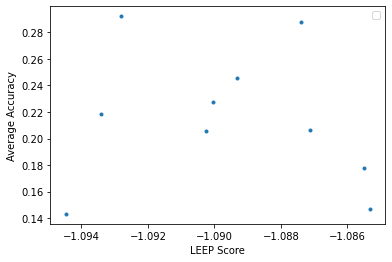

In [235]:
plt.plot(LEEP_sequence, acc_sequence, marker='.', linestyle = 'None')
# axis labels
plt.xlabel('LEEP Score')
plt.ylabel('Average Accuracy')
# show the legend
plt.legend()
# show the plot
plt.savefig("10 Sequences - 5 Tasks - 3 Classes")
plt.show()

In [237]:
np.corrcoef(LEEP_sequence, acc_sequence)[0][1]

-0.1390833706860988

### Check

In [95]:
import random
import time

acc_sequence = []
LEEP_sequence = []

# model = MLP_model(input_shape=len(X[0]))
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

for s in range(NUM_SEQUENCE):
  model = MLP_model(input_shape=len(X[0]))
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  get_logits = Model(inputs=model.input,
                    outputs=model.get_layer(model.layers[-2].name).output)

  choose_class = []
  acc_task_list = []

  buffer = []

  task_list = []

  print("SEQUENCE:", s)
  LEEP_score = []
  for t in range(NUM_TASK):
    print("TASK:", t)
    #pick class
    rand = random.randint(0, 7)
    while rand in choose_class:
      rand = random.randint(0, 7)
    choose_class.append(rand)
    pick_class = [rand]
    count = 0
    while count < NUM_CLASS - 1:
      count =  count + 1
      pick_class.append(pick_class[0]+count)
    
    print(pick_class)
    
    #pick data train
    X_train_choice = []
    y_train_choice = []
    for i in range(len(X)):
      if y[i] in pick_class:
        X_train_choice.append(X[i])
        y_train_choice.append(y[i])
    
    #pick data test
    X_test_choice = []
    y_test_choice = []
    for i in range(len(X_test)):
      if y_test_raw[i] in pick_class:
        X_test_choice.append(X_test[i])
        y_test_choice.append(y_test_raw[i])

    task_list.append([X_train_choice, X_test_choice, y_train_choice, y_test_choice])

    X_train_choice = np.array(X_train_choice)

    # if t>0:
      # LEEP_score.append(LEEP(y_train_choice, model(X_train_choice)))

    y_train_choice =  tf.keras.utils.to_categorical(y_train_choice, num_classes = 10)

    X_test_choice = np.array(X_test_choice)
    # y_test_choice =  tf.keras.utils.to_categorical(y_test_choice, num_classes = 10)

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.SGD()

    for i in range(epochs):
        iterations = len(X_train_choice)//batch_size
        for j in range(iterations):
          if len(buffer) > 0:
            X_buffer, y_buffer, z_buffer = buffer[0], buffer[1], buffer[2]
            X_buffer_batch, y_buffer_batch = batch_data(X_buffer, y_buffer, batch_size)
            reg = np.linalg.norm(z_buffer-get_logits(X_buffer))
          else:
            reg = 0
          X_batch, y_batch = batch_data(X_train_choice, y_train_choice, batch_size)
          with tf.GradientTape() as tape:
              # z_batch = get_logits(X_batch)
              logits = model(X_batch)
              # Compute the loss value for this batch.
              loss_value = lr*(loss_fn(y_batch, logits) + alpha*reg)

          # Update the weights of the model to minimize the loss value.
          gradients = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        buffer = reservoir(buffer, buffer_size, X_train_choice, y_train_choice, np.array(get_logits(X_train_choice)))
        # print(np.array(get_logits(X_train_choice)))
        # print("X:", buffer[0])
        # print("y:", buffer[1])
        # print("z:", buffer[2])

        _, acc = model.evaluate(X_test_choice, tf.keras.utils.to_categorical(y_test_choice, num_classes = 10))
        print("epoch:", i, "loss:", loss_value, "acc:", acc)
      
    acc_list = [-1]*NUM_TASK
    for learned_index in range(len(task_list)):
      _, X_test_learned, _, y_test_learned = task_list[learned_index]
      # print(X_test_learned)
      #acc_list[learned_index] = empirical_predict(model, np.array(X_test_learned), y_test_learned)
      _, acc_list[learned_index] = model.evaluate(np.array(X_test_learned), tf.keras.utils.to_categorical(y_test_learned, num_classes = 10))
    acc_task_list.append(acc_list)
    print("acc of learned task:", acc_list)
    print("-------------------------------------------------")
  acc_sequence.append(np.mean(acc_task_list[-1]))
  # LEEP_sequence.append(np.mean(LEEP_score))
  

SEQUENCE: 0
TASK: 0
[2, 3, 4]
95/95 [==============================] - 1s 4ms/step - loss: 0.2871 - accuracy: 0.9580
epoch: 0 loss: tf.Tensor(0.0027729773, shape=(), dtype=float32) acc: 0.9580026268959045
95/95 [==============================] - 0s 4ms/step - loss: 0.2183 - accuracy: 0.9630
epoch: 1 loss: tf.Tensor(4.4690943, shape=(), dtype=float32) acc: 0.9629629850387573
95/95 [==============================] - 0s 4ms/step - loss: 0.1746 - accuracy: 0.9676
epoch: 2 loss: tf.Tensor(3.714212, shape=(), dtype=float32) acc: 0.9675925970077515
95/95 [==============================] - 0s 4ms/step - loss: 0.1549 - accuracy: 0.9745
epoch: 3 loss: tf.Tensor(3.023974, shape=(), dtype=float32) acc: 0.9745370149612427
95/95 [==============================] - 0s 4ms/step - loss: 0.1345 - accuracy: 0.9752
epoch: 4 loss: tf.Tensor(2.1842155, shape=(), dtype=float32) acc: 0.9751983880996704
95/95 [==============================] - 0s 4ms/step - loss: 0.1394 - accuracy: 0.9759
epoch: 5 loss: tf.Tens

KeyboardInterrupt: ignored

In [ ]:
acc_sequence

In [80]:
import random

acc_sequence = []
LEEP_sequence = []

# model = MLP_model(input_shape=len(X[0]))
# model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

for s in range(NUM_SEQUENCE):
  model = Transfer_model()
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

  get_logits = Model(inputs=model.input,
                    outputs=model.get_layer(model.layers[-2].name).output)

  choose_class = []
  acc_task_list = []

  buffer = []

  task_list = []

  print("SEQUENCE:", s)
  LEEP_score = []
  for t in range(NUM_TASK):
    print("TASK:", t)
    #pick class
    rand = random.randint(0, 7)
    while rand in choose_class:
      rand = random.randint(0, 7)
    choose_class.append(rand)
    pick_class = [rand]
    count = 0
    while count < NUM_CLASS - 1:
      count =  count + 1
      pick_class.append(pick_class[0]+count)
    
    print(pick_class)
    
    #pick data train
    X_train_choice = []
    y_train_choice = []
    for i in range(len(X)):
      if y[i] in pick_class:
        X_train_choice.append(X[i].reshape(28, 28))
        y_train_choice.append(y[i])
    
    #pick data test
    X_test_choice = []
    y_test_choice = []
    for i in range(len(X_test)):
      if y_test_raw[i] in pick_class:
        X_test_choice.append(X_test[i].reshape(28, 28))
        y_test_choice.append(y_test_raw[i])

    task_list.append([X_train_choice, X_test_choice, y_train_choice, y_test_choice])

    X_train_choice = np.array(X_train_choice)

    # if t>0:
      # LEEP_score.append(LEEP(y_train_choice, model(X_train_choice)))

    y_train_choice =  tf.keras.utils.to_categorical(y_train_choice, num_classes = 10)

    X_test_choice = np.array(X_test_choice)
    # y_test_choice =  tf.keras.utils.to_categorical(y_test_choice, num_classes = 10)

    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.SGD()

    for i in range(epochs):
        iterations = len(X_train_choice)//batch_size
        for j in range(iterations):
          if len(buffer) > 0:
            X_buffer, y_buffer, z_buffer = buffer[0], buffer[1], buffer[2]
            X_buffer_batch, y_buffer_batch = batch_data(X_buffer, y_buffer, batch_size)
            reg = np.linalg.norm(z_buffer-model(X_buffer))
          else:
            reg = 0
          # X_aug, y_aug = 
          X_batch, y_batch = batch_data(X_train_choice, y_train_choice, batch_size)
          with tf.GradientTape() as tape:
              logits = model(X_batch)
              # Compute the loss value for this batch.
              loss_value = lr*(loss_fn(y_batch, logits) + alpha*reg)

          # Update the weights of the model to minimize the loss value.
          gradients = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        buffer = reservoir(buffer, buffer_size, X_train_choice, y_train_choice, get_logits(X_train_choice))

        _, acc = model.evaluate(X_test_choice, tf.keras.utils.to_categorical(y_test_choice, num_classes = 10))
        print("epoch:", i, "loss:", loss_value, "acc:", acc)
      
    acc_list = [-1]*NUM_TASK
    for learned_index in range(len(task_list)):
      _, X_test_learned, _, y_test_learned = task_list[learned_index]
      # print(X_test_learned)
      #acc_list[learned_index] = empirical_predict(model, np.array(X_test_learned), y_test_learned)
      _, acc_list[learned_index] = model.evaluate(np.array(X_test_learned), tf.keras.utils.to_categorical(y_test_learned, num_classes = 10))
    acc_task_list.append(acc_list)
    print("acc of learned task:", acc_list)
    print("-------------------------------------------------")
  acc_sequence.append(np.mean(acc_task_list[-1]))
  # LEEP_sequence.append(np.mean(LEEP_score))
  

UnboundLocalError: ignored